In [1]:
import numpy
import os
import pandas

RANDOM_SEED=0
DATA_PATH = os.path.join(os.getcwd(), 'gen_datasets/chexpert/chexpert_hog_resize_shape=(128, 64)_o=9_ppc=8_cpb=2.csv')
MODEL_PATH = os.path.join(os.getcwd(), 'modelos/treinados/hog_u_consider.keras')
data_df = pandas.read_csv(DATA_PATH)

features = data_df.drop(columns=['Label']).to_numpy()
labels = data_df['Label'].to_numpy()

print(features)
print(labels)

[[0.15799879 0.17809662 0.04342581 ... 0.         0.17601855 0.42101863]
 [0.23645896 0.29012555 0.21444759 ... 0.         0.00058234 0.13557668]
 [0.28419694 0.09617668 0.12891653 ... 0.03557584 0.39246887 0.39246887]
 ...
 [0.32055965 0.03100372 0.04735006 ... 0.0026251  0.00351626 0.23427562]
 [0.01246151 0.04152029 0.01517686 ... 0.04008662 0.27849898 0.42178512]
 [0.03481418 0.06405497 0.06740871 ... 0.         0.         0.34597585]]
['pneumonia' 'pneumonia' 'pneumonia' ... 'no pneumonia' 'no pneumonia'
 'no pneumonia']


In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

labels = LabelEncoder().fit_transform(labels)
features = StandardScaler().fit_transform(features)

num_features = features.shape[1]
num_classes = 3

print(labels)
print(features)
print(num_features)

[1 1 1 ... 0 0 0]
[[-0.00334979  1.09332659 -0.52446121 ... -0.4647217   0.83043759
   0.72672367]
 [ 0.61613042  2.37068991  1.54918505 ... -0.4647217  -0.7085085
  -1.16222944]
 [ 0.99304439  0.15926851  0.51211734 ...  0.04864158  2.72916403
   0.53779153]
 ...
 [ 1.28014521 -0.58383912 -0.4768795  ... -0.42684125 -0.68277185
  -0.50907503]
 [-1.15243554 -0.46392831 -0.86698091 ...  0.11373261  1.72940739
   0.73179603]
 [-0.97595062 -0.20698594 -0.23366757 ... -0.4647217  -0.71361683
   0.23011729]]
3780


In [3]:
import keras
from keras import layers
from keras import regularizers
from utils import BiasInitializer

mlp = keras.Sequential(
    [
        layers.Dense(
            96,
            activation='relu',
            kernel_regularizer=regularizers.L2(l2=0.01)
        ),
        layers.Dropout(rate=0.5),
        layers.Dense(
            192,
            activation='relu',
            kernel_regularizer=regularizers.L2(l2=0.01)
        ),
        layers.Dropout(rate=0.5),
        layers.Dense(
            32,
            activation='relu',
            kernel_regularizer=regularizers.L2(l2=0.01)
        ),
        layers.Dropout(rate=0.5),
        layers.Dense(
            32, 
            activation='relu',
            kernel_regularizer=regularizers.L2(l2=0.01)
        ),
        layers.Dropout(rate=0.5),
        layers.Dense(name='output_layer', units=3, activation='softmax')
    ]
)

mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=[
        keras.metrics.F1Score(average='weighted', name='fscore'),
        keras.metrics.AUC(curve='ROC', name='roc_auc'),
        keras.metrics.AUC(curve='PR', name='pr_auc'),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

mlp(numpy.ones((32, num_features)))

bias_init = BiasInitializer(labels)
out_layer = mlp.get_layer('output_layer')
new_biases = bias_init.calculate_biases()
w, _ = out_layer.get_weights()
out_layer.set_weights([w ,new_biases])

mlp.summary()

2024-07-26 16:20:40.046065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 16:20:40.058023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 16:20:40.061607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 16:20:40.071407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 16:20:40.739791: W tensorflow/compiler/tf2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 96)               │       362,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 96)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 192)              │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 192)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 32)               │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 32)               │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (32, 3)                │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,931 (1.48 MB)

 Trainable params: 388,931 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras import utils as k_utils
import tensorflow as tf
from utils import calculate_weight_dict

WEIGHT_DICT = {
    1: 1.2,
    0: 0.85,
    2: 0.5,
}

smote = SMOTE(random_state=0, n_jobs=-1)

x_train, x_held, y_train, y_held = train_test_split(
    features,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=RANDOM_SEED
)

x_val, x_test, y_val, y_test = train_test_split(
    x_held,
    y_held,
    test_size=0.15,
    stratify=y_held,
    random_state=RANDOM_SEED
)

x_train, y_train = smote.fit_resample(x_train, y_train)

y_train = k_utils.to_categorical(y_train)
y_val = k_utils.to_categorical(y_val)
y_test = k_utils.to_categorical(y_test)

train_set = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(buffer_size=1000)
    .batch(32)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_set = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(32)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_set = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(32)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

history = mlp.fit(
    train_set,
    batch_size=32,
    epochs=70,
    validation_data=val_set,
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_pr_auc',
            min_delta=1e-4,
            restore_best_weights=True,
            patience=10
        )
    ],
    # class_weight=WEIGHT_DICT
)

/home/lapis/miniconda3/envs/IC/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe932dc5440>
Traceback (most recent call last):
  File "/home/lapis/miniconda3/envs/IC/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/lapis/miniconda3/envs/IC/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lapis/miniconda3/envs/IC/lib/python3.11/site-packages/threadpool

Epoch 1/70


I0000 00:00:1722021648.496967 3069888 service.cc:146] XLA service 0x7fe73c004760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722021648.496994 3069888 service.cc:154]   StreamExecutor device (0): Quadro P2200, Compute Capability 6.1
2024-07-26 16:20:48.555260: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-26 16:20:48.726232: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1722021651.260573 3069888 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1246/1246 - 12s - 10ms/step - fscore: 0.4859 - loss: 5.0764 - pr_auc: 0.5835 - precision: 0.5360 - recall: 0.5093 - roc_auc: 0.7182 - val_fscore: 0.2696 - val_loss: 4.7228 - val_pr_auc: 0.3270 - val_precision: 0.2519 - val_recall: 0.2111 - val_roc_auc: 0.5514
Epoch 2/70
1246/1246 - 2s - 1ms/step - fscore: 0.5046 - loss: 4.3455 - pr_auc: 0.5731 - precision: 0.5406 - recall: 0.4912 - roc_auc: 0.7153 - val_fscore: 0.3309 - val_loss: 4.3281 - val_pr_auc: 0.3247 - val_precision: 0.2930 - val_recall: 0.2454 - val_roc_auc: 0.5329
Epoch 3/70
1246/1246 - 2s - 1ms/step - fscore: 0.5432 - loss: 3.7010 - pr_auc: 0.6147 - precision: 0.5780 - recall: 0.5175 - roc_auc: 0.7470 - val_fscore: 0.2791 - val_loss: 4.1003 - val_pr_auc: 0.3037 - val_precision: 0.2669 - val_recall: 0.2284 - val_roc_auc: 0.4836
Epoch 4/70
1246/1246 - 2s - 1ms/step - fscore: 0.5810 - loss: 3.1192 - pr_auc: 0.6602 - precision: 0.6193 - recall: 0.5512 - roc_auc: 0.7812 - val_fscore: 0.2149 - val_loss: 4.0353 - val_pr_auc: 0.2904 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


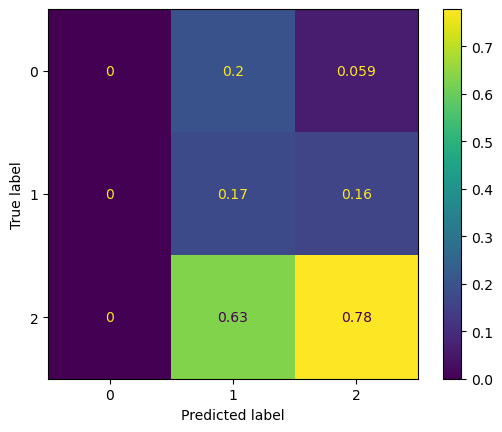

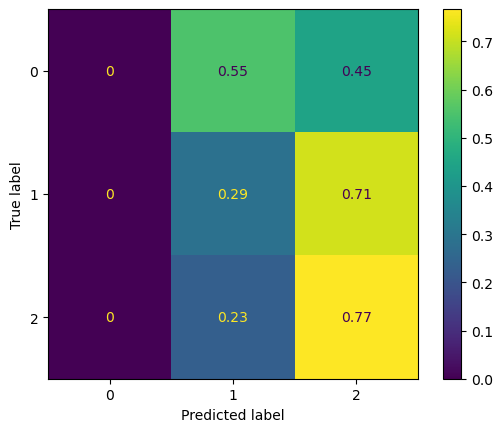

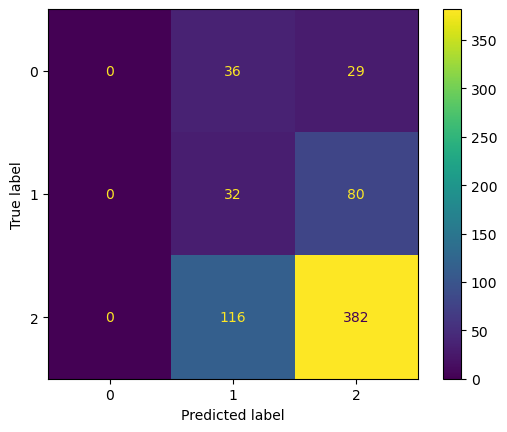

KeyError: 'val_accuracy'

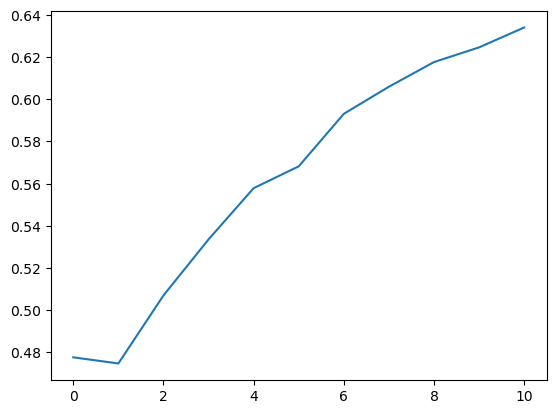

In [ ]:
import numpy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as f1score
import matplotlib.pyplot as plt

y_test = numpy.argmax(y_test, axis=1)
y_pred = numpy.argmax(mlp.predict(test_set), axis=1)

# Plots das matrizes de confusão

# Representa precisão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred')
plt.show()

# Representa recall
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

# Matriz não normalizada
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Plot da precisão do modelo
plt.plot(history.history['fscore'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot do erro do modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

precision, recall, fscore, _ = f1score(
    y_test,
    y_pred,
    beta=1,
    average='weighted'
)

print('===== Validation Set =====')
print(f'| Precision: {precision} | Recall: {recall} | Fscore: {fscore} |')

In [ ]:
mlp.save(MODEL_PATH)